In [15]:
%matplotlib notebook

import itertools
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from tqdm import tqdm

from synthetic_data import load_data_by_gtype
from ic import make_partial_cascade, simulated_infection_time_3d
from graph_generator import add_p_and_delta
from plot_utils import plot_snapshot
from utils import infeciton_time2weight
from ic import source_likelihood_drs, source_likelihood_pair_order, source_likelihood_quad_time_difference
from utils import sp_len_2d

In [20]:
g = load_data_by_gtype('balanced-tree', '2-6')[0]


sp_len = sp_len_2d(g)

In [21]:
pos = graphviz_layout(g)
nx.draw_networkx(g, pos=pos, with_labels=False)

In [22]:
N2 = 500
g = add_p_and_delta(g, 0.2, 1)
inf_time_3d = simulated_infection_time_3d(g, N2)

100%|██████████| 500/500 [00:01<00:00, 403.34it/s]


In [23]:
source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.4)
print(np.sum(np.invert(np.isinf(list(infection_times.values())))))
plot_snapshot(g, pos, infeciton_time2weight(infection_times), queried_nodes=obs_nodes, source_node=source)

2


<IPython.core.display.Javascript object>


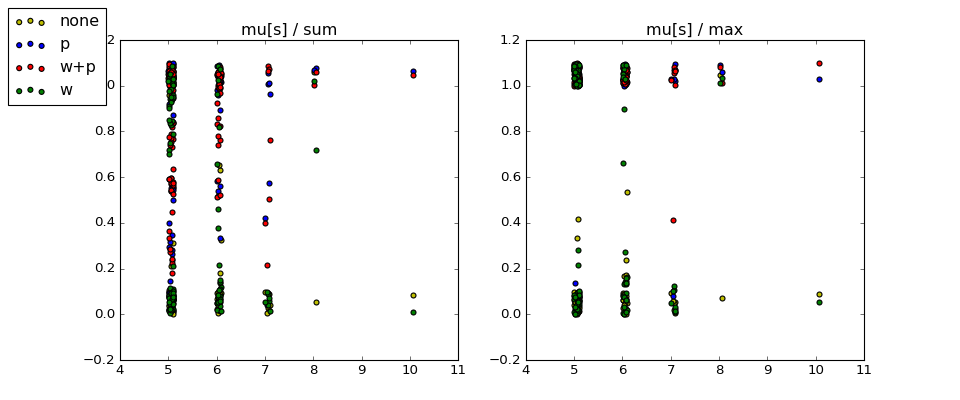

  0%|          | 0/100 [00:00<?, ?it/s]/home/cloud-user/code/source_finding/ic.py:527: RuntimeWarning: invalid value encountered in true_divide
  / counts)
100%|██████████| 100/100 [00:05<00:00, 17.64it/s]


In [24]:
import collections
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cascade_size = []
sum_ratio = collections.defaultdict(list)
max_ratio = collections.defaultdict(list)
for i in tqdm(range(100)):
    infn = 0
    while infn < 5:
        source, obs_nodes, infection_times, tree = make_partial_cascade(g, 1.0)
        infn = np.sum(np.invert(np.isinf(list(infection_times.values()))))
    cascade_size.append(infn)
    for use_weight, use_preconditioning in itertools.product([False, True], [False, True]):    
        if True:
            sll = source_likelihood_drs(g.number_of_nodes(), obs_nodes, inf_time_3d, infection_times, N2,
                                        use_time_weight=use_weight, use_preconditioning=use_preconditioning)
        else:
            sll = source_likelihood_quad_time_difference(
                g.number_of_nodes(), obs_nodes, inf_time_3d, infection_times, N2,
                sp_len=sp_len)
        name = []
        if use_weight:
            name.append('w')
        
        if use_preconditioning:
            name.append('p')
        name = '+'.join(name)
        if name == '':
            name = 'none'
            
        sum_ratio[name].append(sll[source] / sll.sum())
        max_ratio[name].append(sll[source] / sll.max())

lines = []
color_map = {v: c for v, c in zip(['w+p', 'w', 'p', 'none'], ['r', 'g', 'b', 'y'])}
cascade_size = np.array(cascade_size) + 0.1 * np.random.random(len(cascade_size))
for k, ratio in sum_ratio.items():
    l = ax[0].scatter(cascade_size, np.array(ratio) + 0.1 * np.random.random(len(cascade_size)),
                  c=color_map[k])
    lines.append(l)
# ax[0].legend(list(sum_ratio.keys()), loc='upper left')
ax[0].set_title('mu[s] / sum')

for k, ratio in max_ratio.items():
    ax[1].scatter(cascade_size, np.array(ratio) + 0.1 * np.random.random(len(cascade_size)),
                 c=color_map[k])
# ax[1].legend(list(sum_ratio.keys()), loc='bottom left')
ax[1].set_title('mu[s] / max')    

fig.legend(lines, list(sum_ratio.keys()), loc='upper left')

In [25]:
import pandas as pd
df = pd.DataFrame.from_dict(sum_ratio)
df.describe()

,none,p,w,w+p
count,1.000000e+02,1.000000e+02,100.000000,100.000000
mean,1.812084e-01,8.053290e-01,0.334330,0.789640
std,3.654608e-01,2.900587e-01,0.421009,0.270744
min,7.088661e-30,1.125649e-07,0.000006,0.048906
25%,2.545967e-09,4.999931e-01,0.000715,0.553845
50%,6.715526e-06,9.977036e-01,0.026999,0.978922
75%,3.421193e-02,9.999986e-01,0.807083,0.999669
max,9.999964e-01,1.000000e+00,0.999848,1.000000


In [30]:
df = pd.DataFrame.from_dict(max_ratio)
df.describe()

,none,p,w,w+p
count,1.000000e+02,1.000000e+02,100.000000,100.000000
mean,1.965713e-01,9.810375e-01,0.389622,0.993466
std,3.840226e-01,1.336099e-01,0.472326,0.065339
min,7.088661e-30,1.125649e-07,0.000006,0.346606
25%,2.582360e-09,1.000000e+00,0.000807,1.000000
50%,8.329030e-06,1.000000e+00,0.038616,1.000000
75%,3.721496e-02,1.000000e+00,1.000000,1.000000
max,1.000000e+00,1.000000e+00,1.000000,1.000000


- **!!**: without time weight, the modeling is better

for kr-rand graph, strange pattern:

- larger cascade size gives bad result
- small cascade size also gives bad result

<IPython.core.display.Javascript object>


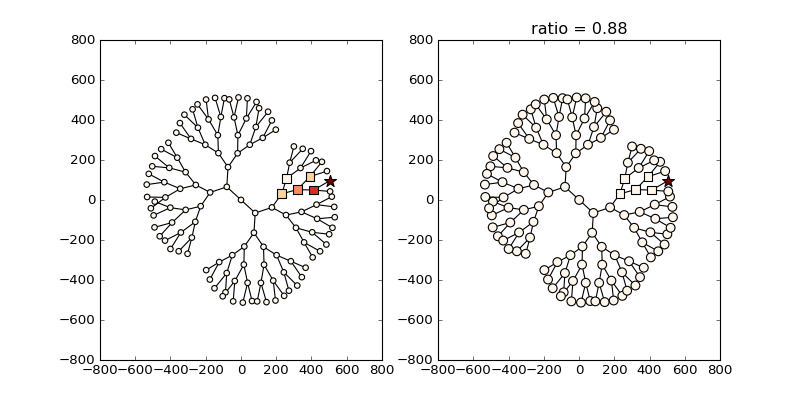

t1=0, t2=3
source reward: 0.10
obs reward: [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
t1=0, t2=3
source reward: 0.10
obs reward: [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
t1=0, t2=1
source reward: 1.00
obs reward: [0.0, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.0]
t1=0, t2=2
source reward: 1.00
obs reward: [0.0, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.0]
t1=0, t2=4
source reward: 0.10
obs reward: [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
t1=3, t2=3
source reward: 0.10
obs reward: [1.0, 0.10000000000000001, 0.0, 0.0, 0.10000000000000001]
t1=3, t2=1
source reward: 0.10
obs reward: [0.0, 0.10000000000000001, 0.10000000000000001, 0.0, 1.0]
t1=3, t2=2
source reward: 0.10
obs reward: [1.0, 0.0, 1.0, 0.0, 1.0]
t1=3, t2=4
source reward: 0.10
obs reward: [1.0,

/home/cloud-user/code/source_finding/ic.py:527: RuntimeWarning: invalid value encountered in true_divide
  / counts)


In [29]:
source_likelihood = source_likelihood_drs
infn = 0
while infn < 5:
    source, obs_nodes, infection_times, tree = make_partial_cascade(g, 1.0)
    infn = np.sum(np.invert(np.isinf(list(infection_times.values()))))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_snapshot(g, pos, infeciton_time2weight(infection_times), ax=ax[0],
              queried_nodes=obs_nodes, source_node=source, 
              max_node_size=250)
sll = source_likelihood(
    g.number_of_nodes(), obs_nodes, inf_time_3d, infection_times, N2,
    source=source,
    debug=True)
weight = {i: v for i, v in enumerate(sll.tolist())}
plot_snapshot(g, pos, weight, ax=ax[1],
              queried_nodes=obs_nodes, source_node=source, max_node_size=250)
ax[1].set_title('ratio = {:.2f}'.format(sll[source] / np.sum(sll)))

<IPython.core.display.Javascript object>


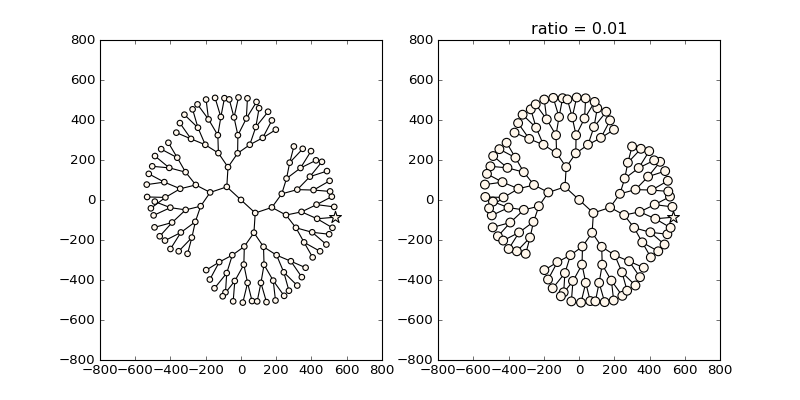

In [26]:
infn = 0
while infn != 1:
    source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.4)
    infn = np.sum(np.invert(np.isinf(list(infection_times.values()))))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_snapshot(g, pos, infeciton_time2weight(infection_times), ax=ax[0],
              queried_nodes=obs_nodes, source_node=source,
              max_node_size=250)
sll = source_likelihood_drs(g.number_of_nodes(), obs_nodes, inf_time_3d, infection_times, 500)
weight = {i: v for i, v in enumerate(sll.tolist())}
plot_snapshot(g, pos, weight, ax=ax[1],
              queried_nodes=obs_nodes, source_node=source, max_node_size=250)
ax[1].set_title('ratio = {:.2f}'.format(sll[source] / np.sum(sll)))

- plot of `mu[source] / mu.max()` is different from `mu[source] / mu.sum()`
- when source is the only infection, estimation does not run
  - estimation does not use **uninfected** node, which could be used however
  - could define the `fraction` parameter to be the fraction of **all** nodes that are observed
- if observing uninfected nodes, the model should change


Questions:

- whether conditioning on the pair is both infected is useful? **yes**
- whether more weight on earlier infection is useful? **a little**
- whether using uninfected nodes is useful? 
- how to deal with sparsity issue? given s, `o1` and `o2` are rarely both infected in the same simulation
  - current approach: assign some smoothing probability (for example, `0.1`)
  - 